# Open Midterm 1

## FINM 36700 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* For every minute late you submit the exam, you will lose one point.

Rules
* The exam is open-material, closed-communication.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.

## Data

**All data files are found in at the course web-book.**

https://markhendricks.github.io/finm-portfolio/. 

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 70     |
| 2       | 30     |

**Numbered problems are worth 5pts unless specified otherwise.**

***

## Submitting your Exam

Your submitted file (ipynb or .zip) must be named in the format...
* `midterm-1-LASTNAME-FIRSTNAME.ipynb`
* `midterm-1-LASTNAME-FIRSTNAME.zip`

Submit the exam via
* Canvas at Assignments/Midterm 1
* If there is any trouble with Canvas, or for a backup, submit it at the course web-book
https://markhendricks.github.io/finm-portfolio/. 

Your submission must be complete.
* If we can't run the notebook to reproduce, it is not complete.

You should either...
* include all helper functions at the top of this notebook in the `Solution Functions` sections.
* submit a zipped folder containing the solution functions

__Exam Submission Structure:__

If you are submitting a zipped folder (because you cannot make the ipynb stand-alone) then use this structure...

```plaintext
exam-open-LASTNAME-FIRSTNAME.zip/
│── exam-open.ipynb
│── data/
│   ├── example_data.csv
│── modules/
│   ├── my_functions.py

***

## Your Functions

Please put all functions needed to run the ipynb here.

* We must be able to run the notebook!
* If you can't get all the functions into this ipynb, then make sure to zip your ipynb and supporting materials and submit the zipped folder.
* But most of you should be able to submit a single, stand-alone ipynb.

In [1]:
# imports

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import math
import datetime
from typing import Union, List


In [2]:
def calc_tangency_weights(
    returns: pd.DataFrame,
    cov_mat: str = 1,
    return_graphic: bool = False,
    return_port_ret: bool = False,
    target_ret_rescale_weights: Union[None, float] = None,
    annual_factor: int = 52,
    name: str = 'Tangency',
    expected_returns: Union[pd.Series, pd.DataFrame] = None,
    expected_returns_already_annualized: bool = False
):
    """
    Calculates tangency portfolio weights based on the covariance matrix of returns.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    cov_mat (str, default=1): Covariance matrix for calculating tangency weights.
    return_graphic (bool, default=False): If True, plots the tangency weights.
    return_port_ret (bool, default=False): If True, returns the portfolio returns.
    target_ret_rescale_weights (float or None, default=None): Target return for rescaling weights.
    annual_factor (int, default=12): Factor for annualizing returns.
    name (str, default='Tangency'): Name for labeling the weights and portfolio.

    Returns:
    pd.DataFrame or pd.Series: Tangency portfolio weights or portfolio returns if `return_port_ret` is True.
    """
    returns = returns.copy()
    
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov() * annual_factor))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.pinv((covmat * annual_factor))  
        
    ones = np.ones(returns.columns.shape) 
    if expected_returns is not None:
        mu = expected_returns
        if not expected_returns_already_annualized:
            mu *= annual_factor
    else:
        mu = returns.mean() * annual_factor
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(
        index=returns.columns,
        data=tangent_return,
        columns=[f'{name} Weights']
    )
    port_returns = returns @ tangency_wts.rename({f'{name} Weights': f'{name} Portfolio'}, axis=1)

    if return_graphic:
        tangency_wts.plot(kind='bar', title=f'{name} Weights')

    if isinstance(target_ret_rescale_weights, (float, int)):
        scaler = target_ret_rescale_weights / port_returns[f'{name} Portfolio'].mean()
        tangency_wts[[f'{name} Weights']] *= scaler
        port_returns *= scaler
        tangency_wts = tangency_wts.rename(
            {f'{name} Weights': f'{name} Weights Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )
        port_returns = port_returns.rename(
            {f'{name} Portfolio': f'{name} Portfolio Rescaled Target {target_ret_rescale_weights:.2%}'},
            axis=1
        )

    if cov_mat != 1:
        port_returns = port_returns.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        tangency_wts = tangency_wts.rename(columns=lambda c: c.replace('Tangency', f'Tangency Regularized {cov_mat:.2f}'))
        
    if return_port_ret:
        return port_returns
    return tangency_wts

def filter_columns_and_indexes(
    df: pd.DataFrame,
    keep_columns: Union[list, str],
    drop_columns: Union[list, str],
    keep_indexes: Union[list, str],
    drop_indexes: Union[list, str],
    drop_before_keep: bool = False
):
    """
    Filters a DataFrame based on specified columns and indexes.

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    keep_columns (list or str): Columns to keep in the DataFrame.
    drop_columns (list or str): Columns to drop from the DataFrame.
    keep_indexes (list or str): Indexes to keep in the DataFrame.
    drop_indexes (list or str): Indexes to drop from the DataFrame.
    drop_before_keep (bool, default=False): Whether to drop specified columns/indexes before keeping.

    Returns:
    pd.DataFrame: The filtered DataFrame.
    """
    if not isinstance(df, (pd.DataFrame, pd.Series)):
        return df
    df = df.copy()
    # Columns
    if keep_columns is not None:
        keep_columns = "(?i)" + "|".join(keep_columns) if isinstance(keep_columns, list) else "(?i)" + keep_columns
    else:
        keep_columns = None
    if drop_columns is not None:
        drop_columns = "(?i)" + "|".join(drop_columns) if isinstance(drop_columns, list) else "(?i)" + drop_columns
    else:
        drop_columns = None
    if not drop_before_keep:
        if keep_columns is not None:
            df = df.filter(regex=keep_columns)
    if drop_columns is not None:
        df = df.drop(columns=df.filter(regex=drop_columns).columns)
    if drop_before_keep:
        if keep_columns is not None:
            df = df.filter(regex=keep_columns)
    # Indexes
    if keep_indexes is not None:
        keep_indexes = "(?i)" + "|".join(keep_indexes) if isinstance(keep_indexes, list) else "(?i)" + keep_indexes
    else:
        keep_indexes = None
    if drop_indexes is not None:
        drop_indexes = "(?i)" + "|".join(drop_indexes) if isinstance(drop_indexes, list) else "(?i)" + drop_indexes
    else:
        drop_indexes = None
    if not drop_before_keep:
        if keep_indexes is not None:
            df = df.filter(regex=keep_indexes, axis=0)
    if drop_indexes is not None:
        df = df.drop(index=df.filter(regex=drop_indexes, axis=0).index)
    if drop_before_keep:
        if keep_indexes is not None:
            df = df.filter(regex=keep_indexes, axis=0)
    return df

def calc_summary_statistics(
    returns: Union[pd.DataFrame, List],
    annual_factor: int = 52,
    provided_excess_returns: bool = None,
    rf: Union[pd.Series, pd.DataFrame] = None,
    var_quantile: Union[float, List] = .05,
    timeframes: Union[None, dict] = None,
    return_tangency_weights: bool = True,
    correlations: Union[bool, List] = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    drop_before_keep: bool = False,
    _timeframe_name: str = None,
):
    """
    Calculates summary statistics for a time series of returns.

    Parameters:
    returns (pd.DataFrame or List): Time series of returns.
    annual_factor (int, default=None): Factor for annualizing returns.
    provided_excess_returns (bool, default=None): Whether excess returns are already provided.
    rf (pd.Series or pd.DataFrame, default=None): Risk-free rate data.
    var_quantile (float or list, default=0.05): Quantile for Value at Risk (VaR) calculation.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate statistics for each period.
    return_tangency_weights (bool, default=True): If True, returns tangency portfolio weights.
    correlations (bool or list, default=True): If True, returns correlations, or specify columns for correlations.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.
    drop_before_keep (bool, default=False): Whether to drop specified columns/indexes before keeping.

    Returns:
    pd.DataFrame: Summary statistics of the returns.
    """
    returns = returns.copy()
    if isinstance(rf, (pd.Series, pd.DataFrame)):
        rf = rf.copy()
        if provided_excess_returns is True:
            raise Exception(
                'rf is provided but excess returns were provided as well.'
                'Remove "rf" or set "provided_excess_returns" to None or False'
            )
        
    if isinstance(returns, list):
        returns_list = returns[:]
        returns = pd.DataFrame({})
        for series in returns_list:
            returns = returns.merge(series, right_index=True, left_index=True, how='outer')
    """
    This functions returns the summary statistics for the input total/excess returns passed
    into the function
    """
    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    try:
        returns.index = pd.to_datetime(returns.index.map(lambda x: x.date()))
    except AttributeError:
        print('Could not convert "date" index to datetime.date')
        pass

    returns = returns.apply(lambda x: x.astype(float))

    if annual_factor is None:
        print('Assuming monthly returns with annualization term of 12')
        annual_factor = 12

    if provided_excess_returns is None:
        print(
            'Assuming excess returns were provided to calculate Sharpe.'
            ' If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"'
        )
        provided_excess_returns = True
    elif provided_excess_returns is False:
        if rf is not None:
            if len(rf.index) != len(returns.index):
                raise Exception('"rf" index must be the same lenght as "returns"')
            print('"rf" is used to subtract returns to calculate Sharpe, but nothing else')

    if isinstance(timeframes, dict):
        all_timeframes_summary_statistics = pd.DataFrame({})
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns for {name} timeframe')
            timeframe_returns = timeframe_returns.rename(columns=lambda c: c + f' {name}')
            timeframe_summary_statistics = calc_summary_statistics(
                returns=timeframe_returns,
                annual_factor=annual_factor,
                provided_excess_returns=provided_excess_returns,
                rf=rf,
                var_quantile=var_quantile,
                timeframes=None,
                correlations=correlations,
                _timeframe_name=name,
                keep_columns=keep_columns,
                drop_columns=drop_columns,
                keep_indexes=keep_indexes,
                drop_indexes=drop_indexes,
                drop_before_keep=drop_before_keep
            )
            all_timeframes_summary_statistics = pd.concat(
                [all_timeframes_summary_statistics, timeframe_summary_statistics],
                axis=0
            )
        return all_timeframes_summary_statistics

    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)
    try:
        if not provided_excess_returns:
            if type(rf) == pd.DataFrame:
                rf = rf.iloc[:, 0].to_list()
            elif type(rf) == pd.Series:
                rf = rf.to_list()
            else:
                raise Exception('"rf" must be either a pd.DataFrame or pd.Series')
            excess_returns = returns.apply(lambda x: x - rf)
            summary_statistics['Sharpe'] = excess_returns.mean() / returns.std()
        else:
            summary_statistics['Sharpe'] = returns.mean() / returns.std()
    except Exception as e:
        print(f'Could not calculate Sharpe: {e}')
    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        summary_statistics[f'Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0)
        summary_statistics[f'Annualized Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
        summary_statistics[f'Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        summary_statistics[f'Annualized Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_statistics['Max Drawdown'] = drawdowns.min()
    summary_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_statistics['Bottom'] = drawdowns.idxmin()

    if return_tangency_weights:
        tangency_weights = calc_tangency_weights(returns)
        summary_statistics = summary_statistics.join(tangency_weights)
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_statistics['Recovery'] = recovery_date
    try:
        summary_statistics["Duration (days)"] = [
            (i - j).days if i != "-" else "-" for i, j in
            zip(summary_statistics["Recovery"], summary_statistics["Bottom"])
        ]
    except (AttributeError, TypeError) as e:
        print(f'Cannot calculate "Drawdown Duration" calculation because there was no recovery or because index are not dates: {str(e)}')

    if correlations is True or isinstance(correlations, list):
        returns_corr = returns.corr()
        if _timeframe_name:
            returns_corr = returns_corr.rename(columns=lambda c: c.replace(f' {_timeframe_name}', ''))
        returns_corr = returns_corr.rename(columns=lambda c: c + ' Correlation')
        if isinstance(correlations, list):
            correlation_names = [c + ' Correlation' for c  in correlations]
            not_in_returns_corr = [c for c in correlation_names if c not in returns_corr.columns]
            if len(not_in_returns_corr) > 0:
                not_in_returns_corr = ", ".join([c.replace(' Correlation', '') for c in not_in_returns_corr])
                raise Exception(f'{not_in_returns_corr} not in returns columns')
            returns_corr = returns_corr[[c + ' Correlation' for c  in correlations]]
        summary_statistics = summary_statistics.join(returns_corr)
    
    return filter_columns_and_indexes(
        summary_statistics,
        keep_columns=keep_columns,
        drop_columns=drop_columns,
        keep_indexes=keep_indexes,
        drop_indexes=drop_indexes,
        drop_before_keep=drop_before_keep
    )

def calc_correlations(
    returns: pd.DataFrame,
    print_highest_lowest: bool = True,
    matrix_size: Union[int, float] = 7,
    return_heatmap: bool = True,
    keep_columns: Union[list, str] = None,
    drop_columns: Union[list, str] = None,
    keep_indexes: Union[list, str] = None,
    drop_indexes: Union[list, str] = None,
    drop_before_keep: bool = False
):
    """
    Calculates the correlation matrix of the provided returns and optionally prints or visualizes it.

    Parameters:
    returns (pd.DataFrame): Time series of returns.
    print_highest_lowest (bool, default=True): If True, prints the highest and lowest correlations.
    matrix_size (int or float, default=7): Size of the heatmap for correlation matrix visualization.
    return_heatmap (bool, default=True): If True, returns a heatmap of the correlation matrix.
    keep_columns (list or str, default=None): Columns to keep in the resulting DataFrame.
    drop_columns (list or str, default=None): Columns to drop from the resulting DataFrame.
    keep_indexes (list or str, default=None): Indexes to keep in the resulting DataFrame.
    drop_indexes (list or str, default=None): Indexes to drop from the resulting DataFrame.
    drop_before_keep (bool, default=False): Whether to drop specified columns/indexes before keeping.

    Returns:
    sns.heatmap or pd.DataFrame: Heatmap of the correlation matrix or the correlation matrix itself.
    """
    returns = returns.copy()

    if 'date' in returns.columns.str.lower():
        returns = returns.rename({'Date': 'date'}, axis=1)
        returns = returns.set_index('date')
    returns.index.name = 'date'

    correlation_matrix = returns.corr()
    if return_heatmap:
        fig, ax = plt.subplots(figsize=(matrix_size * 1.5, matrix_size))
        heatmap = sns.heatmap(
            correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            annot=True,
        )

    if print_highest_lowest:
        highest_lowest_corr = (
            correlation_matrix
            .unstack()
            .sort_values()
            .reset_index()
            .set_axis(['asset_1', 'asset_2', 'corr'], axis=1)
            .loc[lambda df: df.asset_1 != df.asset_2]
        )
        highest_corr = highest_lowest_corr.iloc[lambda df: len(df)-1, :]
        lowest_corr = highest_lowest_corr.iloc[0, :]
        print(f'The highest correlation ({highest_corr["corr"]:.2%}) is between {highest_corr.asset_1} and {highest_corr.asset_2}')
        print(f'The lowest correlation ({lowest_corr["corr"]:.2%}) is between {lowest_corr.asset_1} and {lowest_corr.asset_2}')
    
    if return_heatmap:
        return heatmap
    else:
        return filter_columns_and_indexes(
            correlation_matrix,
            keep_columns=keep_columns,
            drop_columns=drop_columns,
            keep_indexes=keep_indexes,
            drop_indexes=drop_indexes,
            drop_before_keep=drop_before_keep
        )

def calc_cummulative_returns(
    returns: Union[pd.DataFrame, pd.Series],
    return_plot: bool = True,
    fig_size: tuple = (7, 5),
    return_series: bool = False,
    name: str = None,
    timeframes: Union[None, dict] = None,
):
    """
    Calculates cumulative returns from a time series of returns.

    Parameters:
    returns (pd.DataFrame or pd.Series): Time series of returns.
    return_plot (bool, default=True): If True, plots the cumulative returns.
    fig_size (tuple, default=(7, 5)): Size of the plot for cumulative returns.
    return_series (bool, default=False): If True, returns the cumulative returns as a DataFrame.
    name (str, default=None): Name for the title of the plot or the cumulative return series.
    timeframes (dict or None, default=None): Dictionary of timeframes to calculate cumulative returns for each period.

    Returns:
    pd.DataFrame or None: Returns cumulative returns DataFrame if `return_series` is True.
    """
    if timeframes is not None:
        for name, timeframe in timeframes.items():
            if timeframe[0] and timeframe[1]:
                timeframe_returns = returns.loc[timeframe[0]:timeframe[1]]
            elif timeframe[0]:
                timeframe_returns = returns.loc[timeframe[0]:]
            elif timeframe[1]:
                timeframe_returns = returns.loc[:timeframe[1]]
            else:
                timeframe_returns = returns.copy()
            if len(timeframe_returns.index) == 0:
                raise Exception(f'No returns for {name} timeframe')
            calc_cummulative_returns(
                timeframe_returns,
                return_plot=True,
                fig_size=fig_size,
                return_series=False,
                name=name,
                timeframes=None
            )
        return
    returns = returns.copy()
    if isinstance(returns, pd.Series):
        returns = returns.to_frame()
    returns = returns.apply(lambda x: x.astype(float))
    returns = returns.apply(lambda x: x + 1)
    returns = returns.cumprod()
    returns = returns.apply(lambda x: x - 1)
    title = f'Cummulative Returns {name}' if name else 'Cummulative Returns'
    if return_plot:
        returns.plot(
            title=title,
            figsize=fig_size,
            grid=True,
            xlabel='Date',
            ylabel='Cummulative Returns'
        )
    if return_series:
        return returns


#usage to get the cols 
'''
calc_summary_statistics(
    assets_excess_returns[['TIP', 'BWX', 'IEF']],
    annual_factor=12,
    provided_excess_returns=True,
    keep_columns=[
        "Annualized Mean", "Annualized Vol", "Annualized Sharpe",
        "Max Drawdown", "Peak", "Bottom", "Correlation",
        "Annualized Historical VaR", "Kurtosis", "Skewness"
    ]
).transpose()
'''

#Correlations
'''
calc_correlations(assets_excess_returns)
'''

# Cum returns 
'''
calc_cummulative_returns(assets_excess_returns[['TIP', 'BWX', 'IEF']])
'''

# Sharpe V tangency weights

'''
analysis_sharpe_vs_tangent_weights = (
    calc_summary_statistics(
        assets_excess_returns,
        annual_factor=12,
        provided_excess_returns=True,
        keep_columns=['Tangency Weights', 'Annualized Sharpe']
    )
    .sort_values('Annualized Sharpe', ascending=False)
)
analysis_sharpe_vs_tangent_weights
'''

#Tangency weights
'''
calc_tangency_weights(assets_excess_returns, return_graphic=True)

'''


## Allocations - with a mu month target 


# Equal weights - 1/n

'''
n_assets = len(assets_excess_returns.columns)
MU_MONTH_TARGET = 0.010

portfolio_equal_weights_not_scaled = create_portfolio(
    assets_excess_returns,
    weights=[1 / n_assets for _ in range(n_assets)],
    port_name="Equal Weights"
)
portfolio_equal_weights = portfolio_equal_weights_not_scaled * MU_MONTH_TARGET / portfolio_equal_weights_not_scaled.mean()
portfolio_equal_weights
'''


#Risk parity - 1/sigma^2

'''
asset_variance_dict = assets_excess_returns.std().map(lambda x: x ** 2).to_dict()
asset_inv_variance_dict = {asset: 1 / variance for asset, variance in asset_variance_dict.items()}
portfolio_risk_parity_not_scaled = create_portfolio(
    assets_excess_returns,
    weights=asset_inv_variance_dict,
    port_name="Risk Parity"
)
portfolio_risk_parity = portfolio_risk_parity_not_scaled * MU_MONTH_TARGET / portfolio_risk_parity_not_scaled.mean()
portfolio_risk_parity
'''

# Regularised - sigma + diag(sigma) / 2 
'''
portfolio_regularized_not_scaled = calc_tangency_weights(assets_excess_returns, return_port_ret=True, cov_mat=.5, name="Regularized")
portfolio_regularized = portfolio_regularized_not_scaled * MU_MONTH_TARGET / portfolio_regularized_not_scaled.mean()
portfolio_regularized
'''

def stats(data, portfolio = None, portfolio_name = 'Portfolio', annualize = True):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['mean','std'])
    output.loc['sharpe'] = output.loc['mean'] / output.loc['std']
    
    if annualize == True:
        output.loc['mean'] *= 52
        output.loc['std'] *= np.sqrt(52)
        output.loc['sharpe'] *= np.sqrt(52)
    
    if portfolio is None:
        pass
    else:
        output.columns = [portfolio_name]
    
    return output

# Create function to calculate max drawdown and associated dates

def max_drawdown(data, portfolio = None, portfolio_name = 'Portfolio'):
    
    if portfolio is None:
        returns = data
        output = pd.DataFrame(columns=returns.columns)
    else:
        returns = data @ portfolio
        output = pd.DataFrame(columns=[portfolio_name])
    
    cumulative = (returns + 1).cumprod()
    maximum = cumulative.expanding().max()
    drawdown = cumulative / maximum - 1
    
    for col in output.columns:
        
        output.loc['MDD',col] = drawdown[col].min()
        output.loc['Max Date',col] = cumulative[cumulative.index < drawdown[col].idxmin()][col]\
                                             .idxmax()\
                                             .date()
        output.loc['Min Date',col] = drawdown[col].idxmin().date()
        recovery_date = drawdown.loc[drawdown[col].idxmin():,col]\
                                             .apply(lambda x: 0 if x == 0 else np.nan)\
                                             .idxmax()
        
        if pd.isna(recovery_date):
            output.loc['Recovery Date',col] = recovery_date
            output.loc['Recovery Period',col] = np.nan
        else:
            output.loc['Recovery Date',col] = recovery_date.date()
            output.loc['Recovery Period',col] = (output.loc['Recovery Date',col]\
                                             - output.loc['Min Date',col])\
                                             .days
        
    return output

# Create function to retrieve other statistics

def stats_tail_risk(data, portfolio = None, portfolio_name = 'Portfolio', VaR = 0.05):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['skew',
                          'kurt'])
    output.loc['VaR'] = returns.quantile(q = 0.05)
    output.loc['CVaR'] = returns[returns <= output.loc['VaR']].mean()
    output = pd.concat([output, max_drawdown(returns,portfolio,portfolio_name)])
    
    if portfolio is None:
        pass
    else:
        output.columns = portfolio_name
    
    return output

# Create function to display regression stats

def stats_OLS(model,y,x):
    
    output = model.params.to_frame(name = y.columns[0])
    
    return output

import matplotlib.ticker as mtick

def plot_max_drawdown(data, portfolio=None, portfolio_name='Portfolio', ax=None, show_legend=True):
    """
    Plot drawdowns (cumulative peak-to-trough) and annotate the max drawdown window.
    Works with a returns DataFrame/Series, or with a weight vector via `portfolio`.
    """
    # Resolve returns shape and column names
    if portfolio is None:
        returns = data.copy()
        if isinstance(returns, pd.Series):
            returns = returns.to_frame(name=returns.name or portfolio_name)
    else:
        # matrix @ vector -> Series
        returns = (data @ portfolio).to_frame(name=portfolio_name)

    # Compute drawdowns
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = cumulative / running_max - 1.0

    # Prep axes
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
        created_ax = True

    # Plot each series' drawdown
    for col in drawdown.columns:
        dd = drawdown[col]
        ax.plot(dd.index, dd.values, label=col, linewidth=1.5)

        # Identify MDD stats for annotation/shading
        min_date = dd.idxmin()
        mdd_val = dd.loc[min_date]

        # Peak date = last running max before min (highest cumulative up to min_date)
        peak_date = cumulative.loc[:min_date, col].idxmax()

        # Recovery date = first time drawdown returns to 0 after min_date (if ever)
        post = dd.loc[min_date:]
        recovery_candidates = post[post >= -1e-12]
        recovery_date = recovery_candidates.index[0] if len(recovery_candidates) else None

        # Shade peak -> recovery (or to series end if unrecovered)
        shade_end = recovery_date if recovery_date is not None else dd.index[-1]
        ax.axvspan(peak_date, shade_end, alpha=0.12)

        # Annotate the trough
        ax.scatter([min_date], [mdd_val], zorder=3)
        ax.annotate(
            f"MDD: {mdd_val:.2%}\n{min_date.date()}",
            xy=(min_date, mdd_val),
            xytext=(10, 10),
            textcoords="offset points",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7),
            arrowprops=dict(arrowstyle="->", lw=1),
        )

    ax.set_title("Drawdown (Peak → Trough → Recovery)")
    ax.set_ylabel("Drawdown")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(True, linestyle="--", alpha=0.4)
    if show_legend and drawdown.shape[1] > 1:
        ax.legend(frameon=False)
    if created_ax:
        plt.tight_layout()

    return drawdown

# Stats - mean std, sharpe
'''
stats(hf_series) # assumes annualised
'''

# Stats with the tail risk
'''
stats_tail_risk(hf_series) # assumes annualised 
'''


# For generating market beta, treynor and IR
'''
x = sm.add_constant(merrill_factors['SPY US Equity'])

regression_stats = pd.DataFrame(index = ['$B^{SPY}$','Treynor','IR'],columns = hf_series.columns)

for hf in hf_series.columns:
    
    y = hf_series[hf]
    
    model = sm.OLS(y,x).fit()
    
    beta = model.params.iloc[1]
    treynor = 12 * y.mean() / beta
    ir = np.sqrt(12) * model.params.iloc[0] / model.resid.std()
    
    regression_stats[hf] = pd.Series([beta,treynor,ir],index = ['$B^{SPY}$','Treynor','IR'])

regression_stats.round(3)
'''


# OLS stats
'''
y = hf_series[['HFRIFWI Index']]
x = sm.add_constant(merrill_factors)

replication_model = sm.OLS(y,x).fit()

replication_stats = stats_OLS(replication_model,y,x).round(3)
replication_stats

print(f'R-Squared: {round(replication_model.rsquared,2)}')


print(f'The volatility of the tracking error is {round(replication_model.resid.std()*np.sqrt(12),4)}')

'''

# OOS OLS 
'''
t = 60
n = len(hf_series['HFRIFWI Index'])

data = hf_series[['HFRIFWI Index']].copy()
data['Replication'] = np.nan

for i in range(t, n):
    
    y = hf_series['HFRIFWI Index'].iloc[i - 60:i]
    x = sm.add_constant(merrill_factors).iloc[i - 60:i]
    
    m = sm.OLS(y,x).fit()
    
    oos_val = sm.add_constant(merrill_factors).iloc[i].to_numpy().reshape((7))

    rep_val = m.predict(oos_val)
    
    data['Replication'].iloc[i] = rep_val

    
# We can simplify by doing the following:

x = sm.add_constant(merrill_factors)
y = hf_series['HFRIFWI Index']

from statsmodels.regression.rolling import RollingOLS
rolling = RollingOLS(y,x,window=60).fit()
rolling_betas = rolling.params
replication_rolling = (rolling_betas.shift() * x).dropna().sum(axis=1)


oos_loss = (data.dropna().diff(axis=1)**2)['Replication'].sum()
oos_mean = data.dropna()['HFRIFWI Index'].mean()
oos_loss_null = ((data.dropna()['HFRIFWI Index'] - oos_mean)**2).sum()

oos_r2 = 1 - oos_loss / oos_loss_null

print(f'The OOS R-Squared of the replication is {round(oos_r2,4)}')
data.corr().round(3)

'''

#OLS no int 
'''

y = hf_series[['HFRIFWI Index']]
x = merrill_factors

replication_model_no_int = sm.OLS(y,x).fit()

# No-intercept model
stats_OLS(replication_model_no_int,y,x).round(2)

round(replication_model_no_int.predict(x).mean(),4)
round(replication_model.predict(sm.add_constant(x)).mean(),4)

print('Correlation of no intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model_no_int.predict(x))[0][1])
print('Correlation of intercept model to HFRIFWI: ', np.corrcoef(y['HFRIFWI Index'], replication_model.predict(sm.add_constant(x)))[0][1])
'''

# log returns 
'''
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]) : str(y[1])]
        res.append({"mean": sub.mean() * 12, "vol": sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index=[f"{i[0]} - {i[1]}" for i in agg_years]).stack()


df = pd.read_excel(
    "barnstable_analysis_data.xlsx", sheet_name="data", parse_dates=True, index_col=0
)
df["excess_returns"] = df["SPX"] - df["TB1M"]
df_subsample = df.loc["1965":"1999"]


agg_years = [(1965, 1999), (2000, 2024), (1926, 2024)]

sum_stats = df.apply(calc_analytics_by_year, agg_years=agg_years).T
log_sum_stats = np.log(1 + df).apply(calc_analytics_by_year, agg_years=agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product(
    [["levels", "logs"], sum_stats.index.to_list()]
)
res_stats.style.format("{:,.2%}")
'''


#prob underperformance 

'''
def prob_underperformance(mu, sigma, h):
    return norm.cdf(np.sqrt(h) * (-mu / sigma))


mu, sigma = res_stats["1965 - 1999"].loc[("logs", "excess_returns")]

print(
    f"SPX underperforming risk-free rate in the 15 years after 1999: {prob_underperformance(mu=mu, sigma=sigma, h=15):,.2%}"
)
print(
    f"SPX underperforming risk-free rate in the 30 years after 1999: {prob_underperformance(mu=mu, sigma=sigma, h=30):,.2%}"
)

h = np.linspace(0, 30, 300)

probabilities = prob_underperformance(mu=mu, sigma=sigma, h=h)


plt.plot(h, probabilities)
plt.title(
    "Probability of SPX Underperforming Risk-Free Rate\nas a Function of Investment Horizon"
)
plt.xlabel("Investment Horizon (Years)")
plt.ylabel("Probability of Underperformance")
plt.show()
'''

#Full sample 

''' 
# 1965-2024 period
mu = np.log(1 + df.loc["1965":"2023"]).mean() * 12
sigma = np.log(1 + df.loc["1965":"2023"]).std() * np.sqrt(12)
h = np.arange(30) + 1

mu_excess = mu["excess_returns"]
sigma_excess = sigma["excess_returns"]

probabilities_full_sample = prob_underperformance(mu=mu_excess, sigma=sigma_excess, h=h)
print(
    f"SPX underperforming risk-free rate in the 30 years after 2024: {prob_underperformance(mu=mu_excess, sigma=sigma_excess, h=30):,.2%}"
)
'''


#in sample of out of sample likelihood

''' 
mu = (
    res_stats[("1965 - 1999", "mean")].loc[("logs", "SPX")]
    - res_stats[("2000 - 2024", "mean")].loc[("logs", "SPX")]
)
sigma = res_stats[("1965 - 1999", "vol")].loc[("logs", "SPX")]

print(
    f"Probability of underperformance in 2000-2024: {prob_underperformance(mu, sigma, 24):,.2%}"
)
'''

' \nmu = (\n    res_stats[("1965 - 1999", "mean")].loc[("logs", "SPX")]\n    - res_stats[("2000 - 2024", "mean")].loc[("logs", "SPX")]\n)\nsigma = res_stats[("1965 - 1999", "vol")].loc[("logs", "SPX")]\n\nprint(\n    f"Probability of underperformance in 2000-2024: {prob_underperformance(mu, sigma, 24):,.2%}"\n)\n'

***

## Citations

### AI

List any AI tools used in the exam. No need to list prompts, but rather just AI models or IDE integrations.

I expect most students will have something to list here.



*  Chatgpt model 5
* 
* 



### Other resources

Please list any other resources **aside from course materials** from which you used substantially. (No need to list every Google search; just materials from which you used substantially or for specific, original content.) 

I expect most students will not have anything to list here.

* 
* 
* 

***

# Your Name

List your name and CNetID

* Name: Charles Benello
* CNetID: 12248247

***

# 1. Portfolio Analysis

### Data

Use the data in `data/midterm_1_stock_returns.xlsx`.

The returns are...
* excess returns
* weekly
* through `May 2025`

It has returns for
* `25` single-name equities
* `SPY`

In [3]:
import pandas as pd

DATAFILE_STOCKS = '../data/midterm_1_stock_returns.xlsx'
DATAFILE_STOCKS = 'data/midterm_1_stock_returns.xlsx'

SHEET = 'stock rets'
rets = pd.read_excel(DATAFILE_STOCKS, sheet_name=SHEET, index_col='date', parse_dates=['date'])

SHEET = 'benchmark rets'
spy = pd.read_excel(DATAFILE_STOCKS, sheet_name=SHEET, index_col='date', parse_dates=['date'])

display(rets.head())
display(spy.tail())

,ADSK,AOS,BKNG,CBRE,CCI,CF,CHRW,DE,DGX,DTE,...,MRK,MTD,PG,PNR,SBAC,STE,TTWO,VTRS,WM,WMT
date,,,,,,,,,,,,,,,,,,,,,
2015-01-09,-0.021166,-0.008927,-0.078893,-0.000577,0.026536,0.069378,-0.024107,-0.030450,-0.003635,-0.002414,...,0.093897,-0.008843,-0.002101,-0.023393,-0.001091,0.013659,-0.008009,-0.009050,-0.004251,0.040160
2015-01-16,-0.024369,-0.015313,-0.041579,-0.045022,0.012374,0.001515,0.019290,0.019265,0.019738,0.036405,...,0.007512,-0.024325,0.011081,-0.009830,-0.012042,-0.020590,0.048080,0.002865,0.013778,-0.028873
2015-01-23,0.023571,0.016282,0.029527,-0.004231,0.050829,0.013841,0.009121,0.012027,0.016490,0.014229,...,-0.008567,0.037842,-0.005804,-0.003565,0.080951,0.023033,0.022253,-0.031965,0.014548,0.020053
2015-01-30,-0.071920,0.069487,-0.027466,-0.018513,-0.003684,0.012031,-0.039124,-0.035766,0.002540,-0.017317,...,-0.035366,0.002970,-0.064277,-0.033041,-0.014190,-0.014506,-0.004689,-0.019552,-0.029622,-0.039883
2015-02-06,0.056754,0.037577,0.012818,0.048856,0.001733,-0.028619,-0.009970,0.044489,-0.020120,-0.049186,...,-0.024717,0.016318,0.015660,0.040609,0.010108,0.026985,-0.031460,0.013922,0.019639,0.027653


,SPY
date,
2025-04-25,0.046029
2025-05-02,0.029275
2025-05-09,-0.004270
2025-05-16,0.052911
2025-05-23,-0.025395


## 1 Performance Stats

#### 1.1. Calculate the Sharpe ratio for each stock during the sample period
* Recall: the sample period ranges from **2015 to December 2024 (inclusive)**.
* Report the top 5 stocks with the highest Sharpe ratios.

In [4]:
sample = rets.loc[:'2024-12-31']

ss = calc_summary_statistics(
    sample,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False
)

top5_sharpe = ss[['Annualized Sharpe']].sort_values('Annualized Sharpe', ascending=False).head(5)
display(top5_sharpe)

,Annualized Sharpe
WM,0.929781
GOOGL,0.854801
INTU,0.843681
TTWO,0.785463
WMT,0.773420


#### 1.2. Display the correlation matrix for the first ten stocks (columns) over the sample period.
* On average, are these stocks highly correlated? Explain.
* Which of these stocks offer the best diversification benefits?

The highest correlation (58.16%) is between AOS and CBRE
The lowest correlation (12.74%) is between CCI and CF
Average correlation (first 10): 0.347


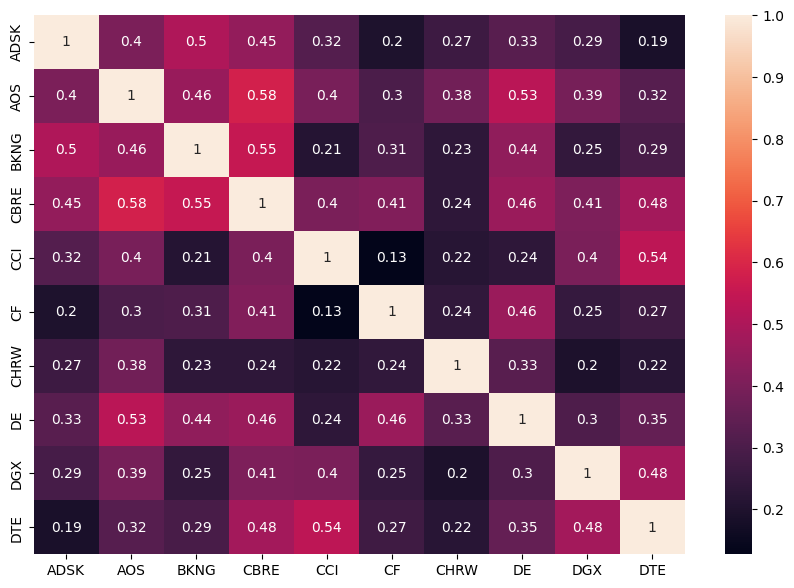

In [5]:
subset10 = sample.iloc[:, :10]

_ = calc_correlations(subset10, print_highest_lowest=True, return_heatmap=True)

# Matrix (for math)
corr_matrix = calc_correlations(subset10, print_highest_lowest=False, return_heatmap=False)
# display(corr_matrix)

avg_corr = corr_matrix.values[np.triu_indices_from(corr_matrix, k=1)].mean()
print(f"Average correlation (first 10): {avg_corr:.3f}")

In [6]:
avg_corr_by_stock = corr_matrix.mean().sort_values()
display(avg_corr_by_stock.head(3))

CHRW    0.331889
CF      0.357515
CCI     0.384330
dtype: float64

* The stocks on average are fairly unccorelated with the coorelations for all of them being bounded between 12.74% and 58.16% with most hovering in the middle with the average being 0.347%
* The stocks that offer the best diversifcation benefits are: CHRW, CF and CCI


## 2. In-Sample Tangency (excess returns)

#### Note
Consider `in-sample` to be all the data through the end of `2024`.

#### 2.1. Construct the tangency portfolio

Using just the in-sample data (through `2024`), calculate the tangency portfolio weights, assuming we have excess returns (existence of a risk-free rate.)
   * Display the ten largest portfolio weights.
   * Plot the Sharpe ratios against the portfolio weights. 

DTE      0.452431
WM       0.364931
GOOGL    0.205688
TTWO     0.198862
DE       0.191454
WMT      0.185139
MRK      0.168538
CBRE     0.167008
PG       0.087959
INTU     0.084542
Name: Tangency Weights, dtype: float64

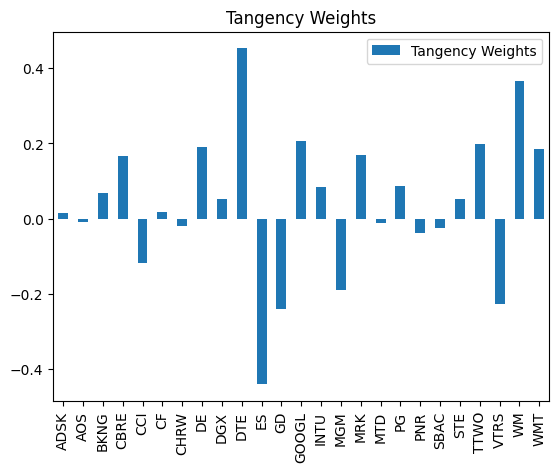

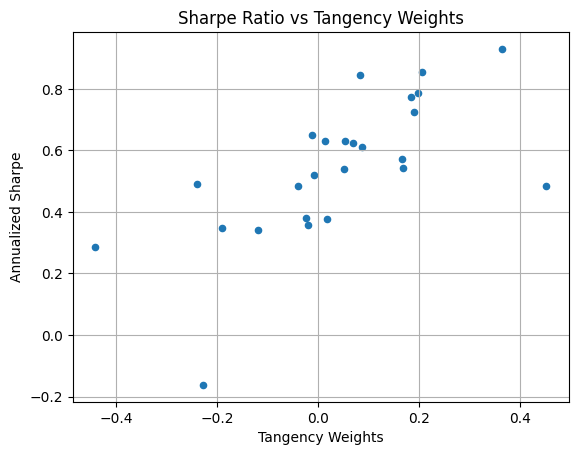

In [7]:
# ===== 2.1 Tangency Portfolio (in-sample through 2024) =====
in_sample = rets.loc[:'2024-12-31']

# Compute tangency weights (already assumes excess returns)
tangency_wts = calc_tangency_weights(
    in_sample,
    annual_factor=52,
    name='Tangency'
)

# Display top 10 largest weights
top10_wts = tangency_wts['Tangency Weights'].sort_values(ascending=False).head(10)
display(top10_wts)

# Compute Sharpe ratios
ss = calc_summary_statistics(
    in_sample,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False
)

# In-sample data
in_sample = rets.loc[:'2024-12-31']

# 1) Show the built-in weights plot (helper has this)
_ = calc_tangency_weights(in_sample, annual_factor=52, name='Tangency', return_graphic=True)

# 2) Get both Sharpe and Tangency Weights from ONE helper, then plot scatter
sw = calc_summary_statistics(
    in_sample,
    annual_factor=52,
    provided_excess_returns=True,
    keep_columns=['Tangency Weights', 'Annualized Sharpe'],   # <- helper returns both
    return_tangency_weights=True,
    correlations=False
)

# Scatter: Sharpe vs. Tangency Weights
sw.plot.scatter(x='Tangency Weights', y='Annualized Sharpe', title='Sharpe Ratio vs Tangency Weights', grid=True)
plt.show()


#### 2.2.

Compare the relationship between tangency portfolio weights and individual sharpe ratios.

The scatter shows a positive relationship - assets with higher individual Sharpe ratios tend to receive larger positive tangency weights, while those with low or negative Sharpe ratios often have small or negative weights.

However there are some outliers noticably bottomthe one in the very bottom left and then also the point that is the furthest right

#### 2.3. Performance of the Tangency

Continue with the in-sample tangency portfolio constructed above, and analyze how it performs in-sample (through `2024`.)

   Report the (annualized)
   * mean
   * volatility
   * Sharpe ratio
   * skewness (not annualized)
   
   Plot the cumulative return of the tangency portfolio over the sample period.

,Tangency Portfolio
Annualized Mean,0.299349
Annualized Vol,0.181059
Annualized Sharpe,1.653325
Skewness,-0.082960


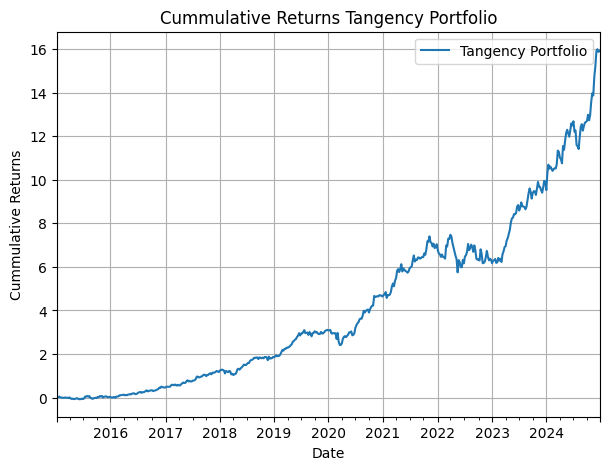

In [8]:
in_sample = rets.loc[:'2024-12-31']

# Use the previously computed tangency weights
tangency_port_rets = calc_tangency_weights(
    in_sample,
    annual_factor=52,
    name='Tangency',
    return_port_ret=True
)

# Summary statistics
tangency_stats = calc_summary_statistics(
    tangency_port_rets,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness']
).T

display(tangency_stats)

# Plot cumulative returns
calc_cummulative_returns(tangency_port_rets, name='Tangency Portfolio', return_plot=True)


## 3. Hedging the Tangency Portfolio

Continue with the in-sample (through 2024) tangency returns calculated in the previous problem.

#### 3.1.

Compute portfolio returns and regress on `SPY` to get $\hat{\beta}$. 

Include an intercept in the regression.

Report $\hat{\beta}$.

#### 3.2. 

Calculate the returns to the hedged position.

   Report the (annualized)
   * mean
   * volatility
   * Sharpe ratio
   * skewness (not annualized)
   

In [9]:
#3.1
in_sample = rets.loc[:'2024-12-31']
spy_in_sample = spy.loc[:'2024-12-31']

# Standardize column names
tp = tangency_port_rets.copy()
tp.columns = ['Tangency']

sp = spy_in_sample.copy()
sp.columns = ['SPY']

# Align and regress
df_reg = tp.join(sp, how='inner').dropna()
y = df_reg[['Tangency']]
x = sm.add_constant(df_reg[['SPY']])
model = sm.OLS(y, x).fit()
beta_hat = model.params['SPY']
print(f"Estimated beta (β̂): {beta_hat:.3f}")


Estimated beta (β̂): 0.605


,Hedged Tangency
Annualized Mean,0.215980
Annualized Vol,0.149947
Annualized Sharpe,1.440382
Skewness,0.169671


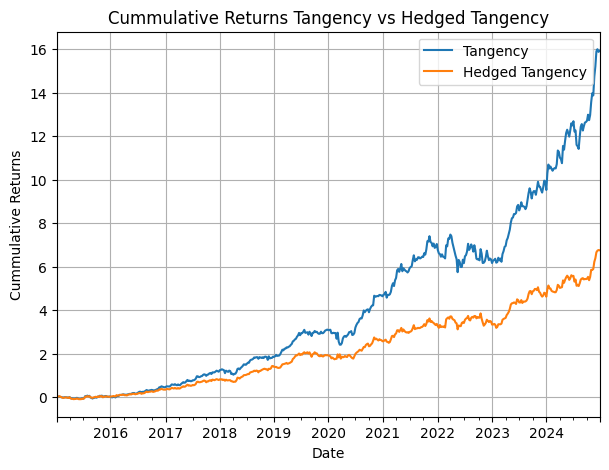

In [10]:
# 3.2 Hedged returns and stats
hedged_rets = (df_reg['Tangency'] - beta_hat * df_reg['SPY']).to_frame('Hedged Tangency')

hedged_stats = calc_summary_statistics(
    hedged_rets,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False,
    keep_columns=['Annualized Mean','Annualized Vol','Annualized Sharpe','Skewness']
).T
display(hedged_stats)

# Cumulative returns plot (optional)
calc_cummulative_returns(pd.concat([tp, hedged_rets], axis=1),
                         name='Tangency vs Hedged Tangency', return_plot=True)

## 4. Out-of-Sample

#### 4.1. Tangency Portfolio Performance: Out-of-Sample (OOS)

Use the weights of the tangency portfolio calculated above.

Compute the out-of-sample returns (`2025`), and just for this OOS portion, report the (annualized)
* mean
* volatility
* Sharpe ratio
* skewness (not annualized)
   
   
#### 4.2. Cumulative performance

* Include the OOS performance in the cumulative return plot (in addition to the in-sample performance).

Show the plot.

In [11]:
#4.1
# Split data
oos = rets.loc['2025-01-01':]        # out-of-sample
in_sample = rets.loc[:'2024-12-31']  # in-sample

# Use the same tangency weights (from 2.1)
tangency_wts = calc_tangency_weights(
    in_sample,
    annual_factor=52,
    name='Tangency'
)

# Compute OOS returns using those weights
tangency_oos_rets = (oos @ tangency_wts).rename(columns={'Tangency Weights': 'Tangency OOS'})

# Summary statistics
tangency_oos_stats = calc_summary_statistics(
    tangency_oos_rets,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness']
).T

display(tangency_oos_stats)

,Tangency OOS
Annualized Mean,0.434554
Annualized Vol,0.216908
Annualized Sharpe,2.003401
Skewness,-0.285264


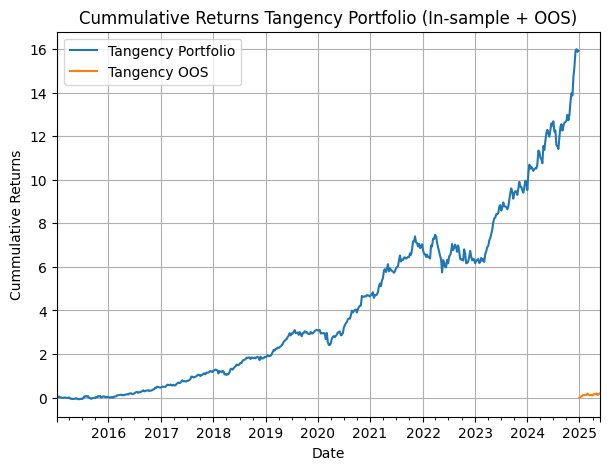

In [12]:
#4.2
# Combine in-sample and OOS returns
combined_rets = pd.concat(
    [calc_tangency_weights(in_sample, return_port_ret=True, annual_factor=52, name='Tangency'),
     tangency_oos_rets],
    axis=0
).sort_index()

# Plot cumulative returns (in-sample + OOS)
calc_cummulative_returns(combined_rets, name='Tangency Portfolio (In-sample + OOS)', return_plot=True)

## 5. Optimizing Hedged Returns

#### 5.1. Construct Market-Hedged Returns

Active managers might optimize their portfolios using market-hedged returns to focus on alpha generation (maximize portion of returns orthogonal to the market). Market-hedged returns are the residuals from regressing each stock’s excess return on the market’s excess return (e.g., `SPY`), effectively removing market beta to isolate stock-specific (idiosyncratic) performance.

* Regress each stock's excess return on the SPY index (quoted in excess return) over the sample period. 
* Include an intercept.
* Report your betas.

In [13]:
#5.1

in_sample = rets.loc[:'2024-12-31']
sp = spy.loc[:'2024-12-31'].iloc[:, 0].rename('SPY')

df = in_sample.join(sp, how='inner').dropna()
m = df['SPY']

# Regress each stock on SPY with intercept; report betas (slope coefficients)
X = sm.add_constant(m)
betas = df.drop(columns='SPY').apply(lambda y: sm.OLS(y, X).fit().params['SPY'])
betas = betas.sort_values(ascending=False).to_frame('Beta_to_SPY')
display(betas)

,Beta_to_SPY
MGM,1.832003
ADSK,1.346120
CBRE,1.325140
PNR,1.298987
INTU,1.291142
BKNG,1.270031
DE,1.127542
MTD,1.083738
GOOGL,1.071698
AOS,1.050560


#### 5.2. The residuals

Save the residuals from each regression as the market-hedged returns. 

Report the `.tail()` (last 5 observations) of the residual dataframe.

In [14]:
#5.2

in_sample = rets.loc[:'2024-12-31']
sp = spy.loc[:'2024-12-31'].iloc[:, 0].rename('SPY')

df = in_sample.join(sp, how='inner').dropna()
X = sm.add_constant(df[['SPY']])

residuals = pd.DataFrame(index=df.index)
for col in in_sample.columns:
    y = df[col]
    residuals[col] = sm.OLS(y, X).fit().resid  # market-hedged return for each stock

display(residuals.tail())

,ADSK,AOS,BKNG,CBRE,CCI,CF,CHRW,DE,DGX,DTE,...,MRK,MTD,PG,PNR,SBAC,STE,TTWO,VTRS,WM,WMT
date,,,,,,,,,,,,,,,,,,,,,
2024-11-29,-0.108049,0.001919,-0.010707,0.017987,-0.000695,-0.013378,-0.026047,0.028463,-0.015035,0.001000,...,0.018365,0.013934,0.009785,0.004557,0.015754,0.010505,-0.009923,-0.028645,0.007773,0.015156
2024-12-06,0.041694,-0.034368,0.009021,-0.026658,-0.047508,-0.022482,-0.000899,-0.058154,-0.039673,-0.039778,...,0.009273,-0.004627,-0.035752,-0.018765,-0.032963,-0.023136,-0.001839,-0.032969,-0.030388,0.028523
2024-12-13,-0.005549,0.004611,-0.006689,0.003625,-0.026479,0.017587,0.059799,-0.002645,-0.010962,0.001563,...,-0.008723,0.021033,-0.013159,-0.000446,-0.022560,-0.002893,-0.020556,0.002421,-0.038362,-0.011696
2024-12-20,0.005347,-0.032718,-0.011464,-0.035024,-0.052567,-0.032651,-0.052474,0.001304,0.001023,0.012541,...,-0.023388,-0.016891,-0.007943,-0.024171,-0.034588,-0.015143,-0.008179,0.012803,-0.024570,-0.013826
2024-12-27,-0.011285,-0.011038,-0.011001,0.002711,-0.005577,-0.009409,-0.008351,-0.014287,-0.008446,0.004969,...,0.012862,-0.004779,0.004561,-0.015779,-0.007017,-0.004276,0.017208,-0.005774,-0.014627,-0.011255


#### 5.3 Diversification Benefits of Market-Hedged Returns

Display the covariance matrix of the market-hedged returns for the first ten stocks.


,ADSK,AOS,BKNG,CBRE,CCI,CF,CHRW,DE,DGX,DTE
ADSK,0.001427,-0.000015,0.000170,0.000012,0.000001,-0.000182,0.000029,-0.000140,-0.000077,-0.000228
AOS,-0.000015,0.000854,0.000054,0.000230,0.000098,0.000070,0.000168,0.000215,0.000066,-0.000022
BKNG,0.000170,0.000054,0.001104,0.000180,-0.000180,0.000069,-0.000045,0.000065,-0.000156,-0.000084
CBRE,0.000012,0.000230,0.000180,0.001020,0.000075,0.000297,-0.000060,0.000068,0.000055,0.000149
CCI,0.000001,0.000098,-0.000180,0.000075,0.000878,-0.000154,0.000021,-0.000105,0.000152,0.000280
CF,-0.000182,0.000070,0.000069,0.000297,-0.000154,0.002509,0.000151,0.000489,0.000057,0.000084
CHRW,0.000029,0.000168,-0.000045,-0.000060,0.000021,0.000151,0.001032,0.000123,-0.000016,0.000010
DE,-0.000140,0.000215,0.000065,0.000068,-0.000105,0.000489,0.000123,0.001133,-0.000028,0.000032
DGX,-0.000077,0.000066,-0.000156,0.000055,0.000152,0.000057,-0.000016,-0.000028,0.000786,0.000201
DTE,-0.000228,-0.000022,-0.000084,0.000149,0.000280,0.000084,0.000010,0.000032,0.000201,0.000667


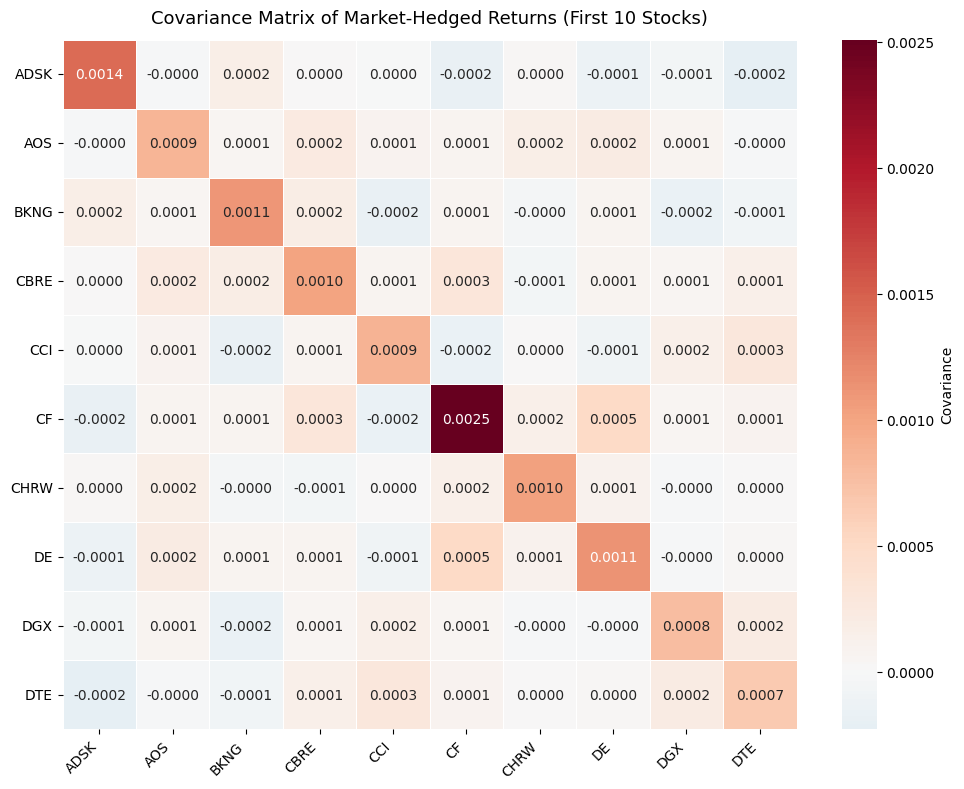

In [15]:
# Subset first 10 hedged residuals
residuals_10 = residuals.iloc[:, :10]
cov_matrix_hedged = residuals_10.cov()

# Display numeric table
display(cov_matrix_hedged.round(6))

# Styled heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_matrix_hedged,
    annot=True,
    fmt=".4f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Covariance'}
)
plt.title("Covariance Matrix of Market-Hedged Returns (First 10 Stocks)", fontsize=13, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 5.4. Portfolio Optimization with Market-Hedged Returns

Construct the tangency portfolio using the alphas (intercept from previous regression) as expected returns and the covariance matrix of the market-hedged returns. Display the portfolio weights.

In [16]:
in_sample = rets.loc[:'2024-12-31']
sp = spy.loc[:'2024-12-31'].iloc[:, 0].rename('SPY')

df = in_sample.join(sp, how='inner').dropna()
X = sm.add_constant(df[['SPY']])

# Compute intercepts (alphas) for each stock
alphas = df.drop(columns='SPY').apply(lambda y: sm.OLS(y, X).fit().params['const'])
alphas = alphas.to_frame('Alpha')

# Construct tangency portfolio using alphas as expected returns, covariance from residuals
tangency_hedged = calc_tangency_weights(
    returns=residuals,
    expected_returns=alphas['Alpha'],
    expected_returns_already_annualized=False,
    annual_factor=52,
    name='Hedged Tangency'
)

display(tangency_hedged.sort_values(by='Hedged Tangency Weights', ascending=False))

,Hedged Tangency Weights
DTE,0.261246
WM,0.212877
GOOGL,0.165559
WMT,0.138082
DE,0.125076
TTWO,0.121184
CBRE,0.110415
MRK,0.109335
INTU,0.091754
PG,0.076923


#### 5.5. Performance of the Tangency of the Hedged

Calculate the returns to the portfolio with weights from the previous question (just in-sample).

   Report the (annualized)
   * mean
   * volatility
   * Sharpe ratio
   * skewness (not annualized)

In [17]:
#5.5
# Compute portfolio returns using hedged tangency weights
hedged_tangency_rets = residuals @ tangency_hedged

# Calculate summary statistics
hedged_tangency_stats = calc_summary_statistics(
    hedged_tangency_rets,
    annual_factor=52,
    provided_excess_returns=True,
    return_tangency_weights=False,
    correlations=False,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Skewness']
).T

display(hedged_tangency_stats)

,Hedged Tangency Weights
Annualized Mean,-1.198125e-16
Annualized Vol,8.954391e-02
Annualized Sharpe,-1.338030e-15
Skewness,1.724773e-01


***

# 2. Managing Risk

In [18]:
DATAFILE = '../data/midterm_1_fund_returns.xlsx'
DATAFILE = 'data/midterm_1_fund_returns.xlsx'
df = pd.read_excel(DATAFILE, sheet_name='fund returns').set_index('date')
df

,fund
date,
2015-01-09,0.003444
2015-01-16,-0.000959
2015-01-23,0.004491
2015-01-30,0.010560
2015-02-06,-0.001624
...,...
2024-11-29,0.013893
2024-12-06,-0.027113
2024-12-13,0.002755


#### 1. Calculating Volatility
Given the return data provided, calculate the annual volatility grouped by year. Annualize this volatility. That is, your answer should be a DataFrame with 10 rows (one for each year from 2015 to 2024) and a single column representing the annualized volatility for that year.

What do you notice about the volatility across different years?

In [19]:
#2.1
annual_vol = df.groupby(df.index.year).std() * np.sqrt(52)
annual_vol.columns = ['Annualized Volatility']
display(annual_vol)

,Annualized Volatility
date,
2015,0.046374
2016,0.175849
2017,0.048981
2018,0.184665
2019,0.056721
2020,0.196581
2021,0.039123
2022,0.206772
2023,0.051441


Volatility fluctuates substantially across years — it’s lowest in stable periods like 2015, 2017, and 2021, and spikes sharply in stress periods such as 2018, 2020, 2022, and 2024.
This pattern reflects how market uncertainty and macro shocks (e.g., COVID-19 in 2020, rate hikes in 2022) drive large increases in annualized volatility.

#### 2. Volatility Estimates

Using the return data, compute the annualized volatility estimate as of the last data point using the following methods:
- EWMA volatility with a half-life of 26 weeks.
- Rolling window volatility with a window size of 52 weeks.

**Note:** do not specify a "min_periods" argument anywhere.

In [20]:
#2.2 
# EWMA volatility (half-life = 26 weeks)
ewma_vol = df.ewm(halflife=26).std() * np.sqrt(52)

# Rolling window volatility (52 weeks)
rolling_vol = df.rolling(window=52).std() * np.sqrt(52)

# Extract the latest values (last data point)
latest_vols = pd.DataFrame({
    'EWMA (26w)': ewma_vol.iloc[-1],
    'Rolling (52w)': rolling_vol.iloc[-1]
})

display(latest_vols)

,EWMA (26w),Rolling (52w)
fund,0.17973,0.216405


#### 3. Dynamic VaR estimates

Using the return data, compute the 1-week 1% VaR as of the last data point in the series.

You should use two different volatility models to compute the VaR:
- EWMA volatility with a half-life of 26 weeks.
- Rolling-window volatility with a window of 52 weeks.
- Empirical (expanding) VaR.

In [21]:
from scipy.stats import norm

# ===== 3. Dynamic 1-Week 1% VaR Estimates =====

alpha = 0.01  # 1% level
z_99 = norm.ppf(alpha)  # ≈ -2.33

# --- 1. EWMA volatility (half-life 26 weeks) ---
ewma_vol = df.ewm(halflife=26).std() * np.sqrt(1)  # 1-week horizon
ewma_var = z_99 * ewma_vol.iloc[-1]

# --- 2. Rolling window volatility (52 weeks) ---
rolling_vol = df.rolling(window=52).std() * np.sqrt(1)
rolling_var = z_99 * rolling_vol.iloc[-1]

# --- 3. Empirical (expanding) VaR ---
empirical_var = df.expanding().quantile(alpha).iloc[-1]

# Combine results
var_table = pd.DataFrame({
    'EWMA (26w)': ewma_var,
    'Rolling (52w)': rolling_var,
    'Empirical (Expanding)': empirical_var
})

display(var_table)

,EWMA (26w),Rolling (52w),Empirical (Expanding)
fund,-0.057982,-0.069814,-0.052816


#### 4. Dynamic CVaR estimates

Repeat Question 3, but instead compute the 1-week 1% Conditional VaR (CVaR) as of the last data point in the series using the same three methods.

In [22]:
# ===== 4. Dynamic 1-Week 1% CVaR Estimates =====
alpha = 0.01
z_99 = norm.ppf(alpha)  # ≈ -2.33
cvar_factor = norm.pdf(z_99) / alpha  # ≈ 2.665 for normal CVaR adjustment

# --- 1. EWMA volatility (half-life 26 weeks) ---
ewma_vol = df.ewm(halflife=26).std() * np.sqrt(1)
ewma_cvar = -cvar_factor * ewma_vol.iloc[-1]

# --- 2. Rolling window volatility (52 weeks) ---
rolling_vol = df.rolling(window=52).std() * np.sqrt(1)
rolling_cvar = -cvar_factor * rolling_vol.iloc[-1]

# --- 3. Empirical (expanding) CVaR ---
empirical_cvar = df.expanding().apply(
    lambda x: x[x <= x.quantile(alpha)].mean()
).iloc[-1]

# Combine results
cvar_table = pd.DataFrame({
    'EWMA (26w)': ewma_cvar,
    'Rolling (52w)': rolling_cvar,
    'Empirical (Expanding)': empirical_cvar
})

display(cvar_table)

,EWMA (26w),Rolling (52w),Empirical (Expanding)
fund,-0.066428,-0.079983,-0.065762


#### 5. Year Choice

Suppose instead we were interested in our VaR estimates as of the end of 2023 (ie. use all data that is before 2024-01-01). Report your VaR (1-week, 1%) estimates using the same three methods as in Question 3, but now the last data point in 2023.

Hint: You can use `df.loc[:'2023']` to filter the DataFrame to only include data up to the end of 2023.

In [23]:
#2.5
alpha = 0.01
z_99 = norm.ppf(alpha)  # ~ -2.326

df_2023 = df.loc[:'2023'].dropna()

# EWMA(26w) volatility and VaR
ewma_vol_2023 = df_2023.ewm(halflife=26).std()
ewma_var_2023 = z_99 * ewma_vol_2023.iloc[-1]

# Rolling(52w) volatility and VaR
roll_vol_2023 = df_2023.rolling(window=52).std()
roll_var_2023 = z_99 * roll_vol_2023.iloc[-1]

# Empirical (expanding) VaR
emp_var_2023 = df_2023.expanding().quantile(alpha).iloc[-1]

var_2023 = pd.DataFrame({
    'VaR 1w 1% — EWMA(26w)': ewma_var_2023,
    'VaR 1w 1% — Rolling(52w)': roll_var_2023,
    'VaR 1w 1% — Empirical': emp_var_2023
})
display(var_2023)

,VaR 1w 1% — EWMA(26w),VaR 1w 1% — Rolling(52w),VaR 1w 1% — Empirical
fund,-0.032412,-0.016595,-0.049635


### 6. Compare

What do you notice about the VaR estimates compared to those from question `2.2`?

This answer is if you want all var estimates from previous question

The VaR estimates are noticeably larger in magnitude (more negative) than the volatility estimates from 2.2.
That’s expected because:
- Volatility (in 2.2) measures overall variation, while VaR isolates the extreme 1 % left-tail risk.
- Both use the same volatility models (EWMA 26 w and Rolling 52 w), but VaR multiplies volatility by a 1 % quantile (≈ −2.33), scaling it to tail losses.
- Consequently, EWMA VaR reacts quickly to recent spikes in volatility, Rolling VaR is smoother, and Empirical VaR reflects realized extremes and can be even more conservative when large negative returns exist in history.

In short, VaR translates volatility into a measure of expected extreme loss—it’s directionally consistent with 2.2 but significantly deeper in the negative tail.

This is for just 2.5

The VaR estimates as of the end of 2023 are larger in magnitude (more negative) than the volatility estimates from Question 2.2. This is expected because VaR scales volatility by the 1 % quantile of the normal distribution (≈ −2.33), converting overall variability into an estimate of extreme downside risk.

Specifically:
- The EWMA VaR responds most strongly to recent volatility, giving the most reactive tail estimate.
- The Rolling 52-week VaR is smoother, reflecting average conditions over the past year.
- The Empirical VaR directly reflects realized tail losses and can be even more conservative if past returns include sharp drawdowns.
